# Assignment 1: Data Description & Exploratory Data Analysis

### Group 35: Prasojo, Naufal (14303440)

### Section 1: Data Description

**1.1 Data Summary**
- **Dataset Name:** Airbnb Prices in European Cities
- **Source:** Kaggle dataset by The Devastator (2021). Available at
https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities?utm_source=chatgpt.com
- **License:** CC BY-NC 4.0 (Attribution-NonCommercial).
- **Data Collection:** Listings were web-scraped from Airbnb for 10 European cities (Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna), but for this assignment we only use Athens data.
     - Each city has two files (weekday and weekend) capturing snapshot prices for 2-night stays for two guests.
     - Approx. 2627~2653 observations (rows) and 19 variables (columns).



**Variable Description**

| Variable Name                        | Type                | Description                                                         |
| :----------------------------------- | :------------------ | :------------------------------------------------------------------ |
| `realSum`                            | Numeric             | Total price (in euros) for the stay.                                |
| `room_type`                          | Categorical         | Type of accommodation (Entire home/apt, Private room, Shared room). |
| `room_shared`                        | Boolean             | 'True' if room is shared; 'False' otherwise.                                   |
| `room_private`                       | Boolean             | 'True' if room is private; 'False' otherwise.                                  |
| `person_capacity`                    | Integer             | Maximum number of guests.                                           |
| `superhost`                          | Boolean             | 'True' if host is a Superhost status; 'False' otherwise.                       |
| `multi`                              | Boolean             | 'True' if host owns 2–4 listings; 'False' otherwise.                           |
| `biz`                                | Boolean             | 'True' if host is a business (>4 listings).                              |
| `cleanliness_rating`                 | Numeric (1–10)      | Guest-reported cleanliness rating.                                  |
| `guest_satisfaction_overall`         | Numeric (1–100)     | Overall guest satisfaction score.                                   |
| `bedrooms`                           | Integer             | Number of bedrooms (0 for studio).                                  |
| `dist`                               | Numeric             | Distance from city centre (km).                                     |
| `metro_dist`                         | Numeric             | Distance from nearest metro station (km).                           |
| `attr_index`                         | Numeric             | Local attraction density index.                                     |
| `rest_index`                         | Numeric             | Local restaurant density index.                                     |
| `attr_index_norm`, `rest_index_norm` | Numeric             | Normalized versions of indices for comparability across cities.     |
| `lng`, `lat`                         | Numeric             | Longitude and latitude coordinates of listing.                      |



**1.2 Source and Information**

The data were collected by web-scraping Airbnb public listings around 2020–2021 by The Devastator. The author compiled cleaned CSV files for each city and time category (weekday vs weekend) and license as CC BY-NC 4.0 (Attribution-NonCommercial).

**1.3 Pre-Selection of Variables**

- Variables to keep:

`realSum`, `room_type`, `person_capacity`, `superhost`, `cleanliness_rating`, `guest_satisfaction_overall`, `dist`, `metro_dist`, `attr_index`, `rest_index`,  `weekday/weekend`.

Reasoning: These variables seem most useful for both understanding factors for Airbnb prices or for building a model that can help estimate fair prices for future listings in Athens.

- Variables to drop (initial cleaning phase):

    - `lng`, `lat` – spatial coordinates not needed for non-map models (but can be added later for spatial EDA).
    - `attr_index_norm`, `rest_index_norm` – correlated with non-normalized versions and may introduce redundancy.
    - `multi`, `biz` – may be reintroduced if host type becomes an interest variable, but initial models will focus on inference model for price.

Reasoning: Variables dropped contain redundant or identifier information not directly useful for predictive or interpretive modelling. All decisions will be re-evaluated after EDA.


### Section 2: Scientific Question

**2.1 Question**

I would like to model and predict listing prices in European Airbnb across various listing Characteristic (e.g `room_type`, `person_capacity`, `superhost`, etc) and Quantitative data (e.g `dist`, `metro_dist`, `attr_index`, etc). 

**2.2 Name the response**

The response variable is `realSum`, representing the total price of the Airbnb listing i Europe (especially in Athens where we focus on).

**2.3 Explain whether your question is focused on prediction, inference, or both**

My question focuses on both prediction and inference. I aim to identify which listing and location features significantly influence Airbnb prices (inference) while also building a model that can accurately predict the price of future listings based on these factors.



### Section 3: Exploratory Data Analysis and Visualization 

In [78]:
# List CSV files in ./data
csv_files <- list.files("data", pattern = "\\.csv$", full.names = TRUE)
csv_files

# Read each CSV into a named list of data.frames
data_list <- lapply(csv_files, read.csv, stringsAsFactors = FALSE)
names(data_list) <- basename(csv_files)  # names are file names

# # Quick preview: show number of rows and first few rows for each
# lapply(data_list, function(df) {
#   list(rows = nrow(df), cols = ncol(df), head = head(df, 3))
# })

[1] "data/amsterdam_weekdays.csv" "data/amsterdam_weekends.csv"
 [3] "data/athens_weekdays.csv"    "data/athens_weekends.csv"   
 [5] "data/barcelona_weekdays.csv" "data/barcelona_weekends.csv"
 [7] "data/berlin_weekdays.csv"    "data/berlin_weekends.csv"   
 [9] "data/budapest_weekdays.csv"  "data/budapest_weekends.csv" 
[11] "data/lisbon_weekdays.csv"    "data/lisbon_weekends.csv"   
[13] "data/london_weekdays.csv"    "data/london_weekends.csv"   
[15] "data/paris_weekdays.csv"     "data/paris_weekends.csv"    
[17] "data/rome_weekdays.csv"      "data/rome_weekends.csv"     
[19] "data/vienna_weekdays.csv"    "data/vienna_weekends.csv"

In [79]:
# In R console:# 
# R.version.string# 
# versioninstall.packages("cowplot")install.packages("glmbb")


In [80]:
library(broom)
library(MASS)
library(dplyr)
library(glmbb)
library(cowplot)
library(tidyverse)
library(faraway)
library(ggplot2)

athens_weekdays <- data_list[["athens_weekdays.csv"]]
athens_weekends <- data_list[["athens_weekends.csv"]]

athens_weekdays <- athens_weekdays %>% select(-lng, -lat, -attr_index_norm, -rest_index_norm, -multi, -biz)
athens_weekends <- athens_weekends %>% select(-lng, -lat, -attr_index_norm, -rest_index_norm, -multi, -biz)

head(athens_weekdays)
head(athens_weekends)

,X,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index
,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,129.82448,Entire home/apt,False,False,4,False,10,100,2,2.8139635,0.8818900,55.34857,78.77838
2,1,138.96375,Entire home/apt,False,False,4,True,10,96,1,0.4072929,0.3045679,240.30665,407.16770
3,2,156.30492,Entire home/apt,False,False,3,True,10,98,1,1.2372111,0.2884881,199.50737,395.96740
4,3,91.62702,Entire home/apt,False,False,4,True,10,99,1,4.3674572,0.2974673,39.80305,58.70658
5,4,74.05151,Private room,False,True,2,False,10,100,1,2.1941850,0.3852657,78.73340,113.32597
6,5,113.88934,Entire home/apt,False,False,6,True,10,96,2,2.0712056,0.4538674,96.58899,158.64432


,X,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index
,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,138.96375,Entire home/apt,False,False,4,True,10,96,1,0.4072777,0.3045697,240.30650,407.16796
2,1,91.62702,Entire home/apt,False,False,4,True,10,99,1,4.3674631,0.2974735,39.80300,58.70652
3,2,76.62925,Private room,False,True,2,False,10,100,1,2.1941738,0.3852475,78.73400,113.32668
4,3,151.85246,Entire home/apt,False,False,4,True,10,100,2,2.5089816,0.5634735,68.77488,101.16207
5,4,98.65723,Entire home/apt,False,False,2,True,10,95,1,2.7405814,0.7250455,62.90286,92.61113
6,5,173.88044,Entire home/apt,False,False,4,True,10,97,1,0.8690264,0.4707861,132.33536,221.33873


In [81]:
columns <- colnames(athens_weekdays)
columns

[1] "X"                          "realSum"                   
 [3] "room_type"                  "room_shared"               
 [5] "room_private"               "person_capacity"           
 [7] "host_is_superhost"          "cleanliness_rating"        
 [9] "guest_satisfaction_overall" "bedrooms"                  
[11] "dist"                       "metro_dist"                
[13] "attr_index"                 "rest_index"

In [86]:
# Just to check room types / room shared
# room_shared_weekends <- athens_weekends[athens_weekends$room_shared == 'True', ]
# room_shared_weekends

# Summary statistics
summary(athens_weekdays$realSum)
summary(athens_weekends$realSum)

"number obeservations for realSum >= 2000: "
nrow(athens_weekdays[athens_weekdays$realSum >= 2000, ])

athens_weekdays_clean <- athens_weekdays %>% filter(realSum < 2000)
summary(athens_weekdays_clean$realSum)
    
athens_weekends_clean <- athens_weekends %>% filter(realSum < 2000)
summary(athens_weekends_clean$realSum)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   42.88    99.59   127.72   155.87   171.54 18545.45 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  42.88   98.66  127.72  147.58  171.54 1043.28 

[1] "number obeservations for realSum >= 2000: "

[1] 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  42.88   99.59  127.72  148.93  171.36 1043.28 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  42.88   98.66  127.72  147.58  171.54 1043.28 

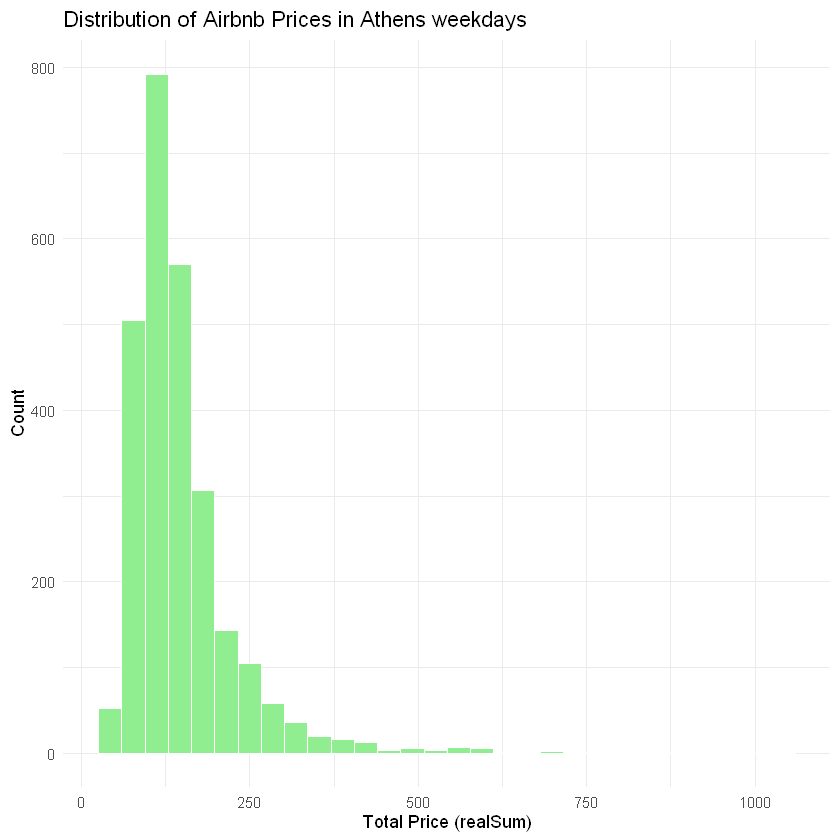

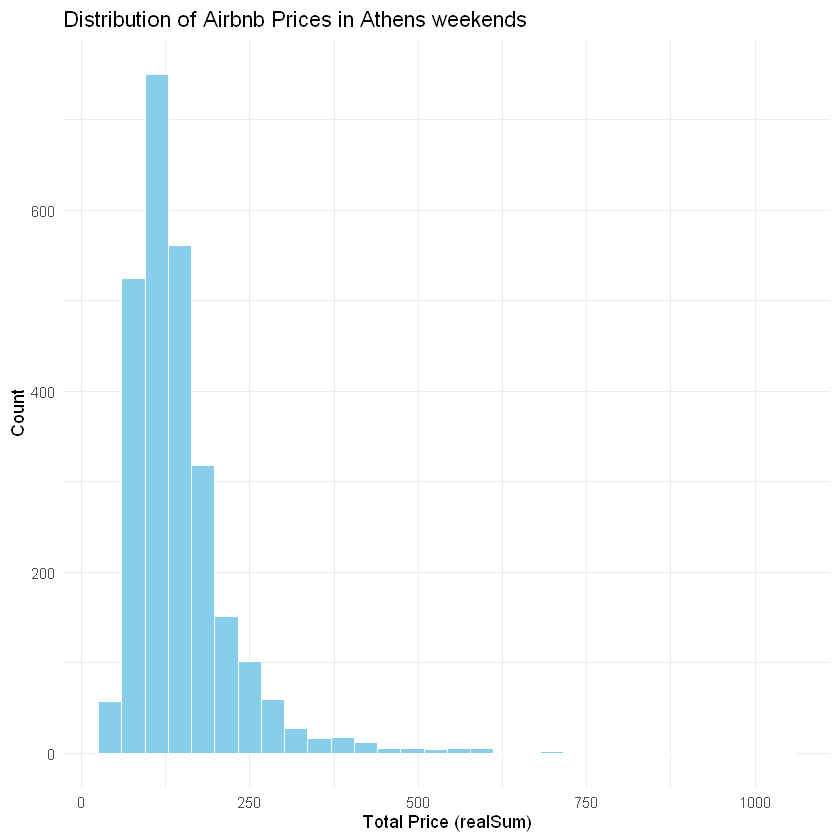

In [90]:
distribution_price_weekends <- ggplot(athens_weekends_clean, aes(x = realSum)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "white") +
    labs(title = "Distribution of Airbnb Prices in Athens weekends",
        x = "Total Price (realSum)",
        y = "Count") +
    theme_minimal()

distribution_price_weekdays <- ggplot(athens_weekdays_clean, aes(x = realSum)) +
    geom_histogram(bins = 30, fill = "lightgreen", color = "white") +
    labs(title = "Distribution of Airbnb Prices in Athens weekdays",
        x = "Total Price (realSum)",
        y = "Count") +
    theme_minimal()

distribution_price_weekdays
distribution_price_weekends